# Can you snatch defeat from the jaws of victory?
**Source**: [Riddler Classic](https://fivethirtyeight.com/features/can-you-snatch-defeat-from-the-jaws-of-victory/). 13 November 2020.

Solution written by Ravi Dayabhai.

**Note to the Reader**: This is only very lightly edited for brevity. It is more a chronicling of my thought processes than anything else.

>From Angela Zhou comes a bad football puzzle. The puzzle’s great, but the football is bad:
>
> Football season is in full swing, and with it have been some incredible blown leads. The Atlanta Falcons know a few things about this, not to mention a certain Super Bowl from a few years back. Inspired by these improbabilities, Angela wondered just how likely one blown lead truly is.
>
> The Georgia Birds and the Michigan Felines play a game where they flip a fair coin 101 times. In the end, if heads comes up at least 51 times, the Birds win; but if tails comes up at least 51 times, the Felines win.

**Question**:

> What’s the probability that **the Birds have at least a 99 percent chance of winning at some point during the game** — meaning their probability of victory is 99 percent or greater given the flips that remain — and **then proceed to lose**?

## Framing the Problem

Immediately, we recognize that the *unconditional* distribution of the **number of heads in one game** is $\text{Bin}(101, \frac{1}{2})$. So, let's let $X \sim \text{Bin}(101, \frac{1}{2})$ where $X$ counts the number of heads in one game.

Let's define two events:

$$
\begin{align}
A &\equiv\, \text{the Birds have $\geq$ 99\% chance of winning at some point in game}\\
B &\equiv\, \text{the Birds lose game}
\end{align}
$$

The general approach is to condition on the games in which the probability of the Birds winning is at some point $\geq 99\%$. Once we've conditioned on these set of games, we simply need to isolate the games in which the Birds ended up losing, i.e., $P(B|A)$.

We are ultimately interested in $P(A \cap B) = P(B|A)P(A) = P(A|B)P(B)$.

## Getting a Feel for Things

Figuring out which games comprise event $A$ is the trickiest part of this problem. Let's see if we can generate a few examples so we can gain some comfort around what it means to "have at least a $99\%$ change of winning *at some point during the game*."

What statements can we make right now that might help us better define on this event? A few, in fact:

- The Birds will win with complete certainty (i.e., $P(\neg B) = 1$) when $\gt 50$ heads have *already* occurred (we'll call the number of heads already observed $H$) **and** the remaining number of flips $R \leq 50$.
- Negating the above, we can also say $P(\neg B) \lt 1$ when $H \leq 50$ **or** $R > 50$.
- We also know that $R + H \leq 101$.
- The number of tails is entailed (🙃) by $R$ and $H$, so $T = 101 - (R + H)$.

Intuitively, we might guess that in order to have at least a $99\%$ chance of winning, the Birds probably already "scored" close to the requisite $51$ heads and in order to win and the Felines will need virtually all of the remaining $r$ flips to be tails.

### Test Intuition with an Example

For example, **what would the probability of the Birds winning be if $R = 10$ and $H = 50$**?  Observe that $R = 10 \cap H = 50 \implies T = 41$; in English, if we've seen $50$ heads and $10$ tosses remain, it must mean we've seen $41$ tails.

The Birds in this particular case need only $1$ more heads over the remaining $10$ coin flips to win. This means to lose, it would require *all* $10$ flips to land tails. Hence, $P(B | R = 10 \cap H = 50) = \binom{10}{10}\frac{1}{2}^{10} = 0.0009765625$. The complement of this is what we care about: 

$$
P(\neg B | R = 10 \cap H = 50) = 1 - P(B | R = 10 \cap H = 50) = 1 - 0.0009765625 = 0.9990234375 \geq 0.99
$$

Yep, looks like our intuition was right. Now, to generalize, **if a game is ever in a state where $R =r \cap H = h$ such that $P(\neg B | R = r \cap H = h) \geq 0.99$, this game comprises the event $A$.**

From what we've been able to deduce thus far, we see that $51-H$ is the *incremental* number of heads needed to secure a Birds victory. Said another way, of the remaining $R$ flips, the Birds can only lose if $51-H-1 = 50-H$ *or fewer* heads are realized.

If we let $W$ count the number of heads at the end of the game, then we can calculate $P(B | R=r \cap H=h)$ by summing all cases where The Birds final score is short of winning, i.e., $50 \geq w \geq h$ for each choice of $r, h$. Simply, $50-W$ is the number of heads the Birds are able to pick up from the $R$ remaining coin flips.

$$
\begin{align}
P(\neg B | R = r \cap H = h) &= 1 - \sum_{50 \geq w \geq h} \binom{r}{50-w}\left(\frac{1}{2}\right)^{r} \geq 0.99 \iff 0.01 \geq \sum_{50 \geq w \geq h} \binom{r}{50-w}\left(\frac{1}{2}\right)^{r} = P(B | R = r \cap H = h) \gt 0
\end{align}
$$

**Observation**: 

In the above equation, $r$ must be greater than $6$ because if $r \leq 6$, then $\left(\frac{1}{2}\right)^{6} > 0.01$ so the entire inequality doesn't hold because the binomial coefficient is $1$ at a minimum where we test the extreme case where there is only one $w$ for our choice of $h$ (i.e., 50 heads already observed). This is an intersting finding: in a game where the Birds have a $50$ heads banked, **the Felines need at least $7$ remaining tosses in order to even have a chance to mount a comeback.**

## Searching Game State Space

We can search over all combinations of $R=r, H=h$ that meet our constraints, which are:

- $r + h \leq 101$
- $h \leq 50$, otherwise the result of the game is already forgone, i.e., $P(\neg B) = 1$.
- $0.01 \geq \sum_{50 \geq w \geq h} \binom{r}{50-w}\left(\frac{1}{2}\right)^{r} \gt 0$

In [29]:
import numpy as np
from scipy.special import comb
import pandas as pd
from itertools import product

# Define conditional probability of the Birds losing given R=r, H=h
def p_B_given_r_h(r, h):
    """
    Returns P(B | R=r, H=h) for valid choices of r, h otherwise returns np.nan
    """
    
    if (r + h > 101) or (h > 50):
        return np.nan

    # Consider different ways the Felines can win given R=r, H=h
    p = 0
    for w in range(h, 50 + 1):
        p += comb(r, 50-w, exact=True) * (0.5) ** r
    
    return p

# Construct state space
state_space = product(range(101 +1), range(101 +1))
data_dict = {}
for r, h in state_space:
    data_dict[(r,h)] = p_B_given_r_h(r, h)
    
# Test case that we considered earlier
data_dict[10, 50]

0.0009765625

Now with the state space enumerated, we can see what choices of $R = r, H = h$ meet the third constraint:

In [30]:
# Return the r, h that meets conditions of A
states_for_A = []
for k, v in data_dict.items():
    if v <= 0.01 and v > 0:
        states_for_A.append(k)
        
# Number of game states that could qualify a game for A
len(states_for_A)

632

From our result above, we see that there are $632$ game states where the Birds have a $\geq 99\%$ of winning.

However, these game states are *not* disjoint. Any given game could exhibit multiple of these game states.

In [31]:
print(f"{states_for_A[-1][0]} flips remaining and {states_for_A[-1][1]} heads observed at one point in game...")
print(f"...after {states_for_A[-1][0]-states_for_A[-10][0]} coin tosses...")
print(f"{states_for_A[-10][0]} flips remaining and {states_for_A[-10][1]} heads observed at a later point in the game")

80 flips remaining and 21 heads observed at one point in game...
...after 5 coin tosses...
75 flips remaining and 26 heads observed at a later point in the game


We should expect to see a pattern for what combinations of $R = r, H = h$ qualify a game for $A$:

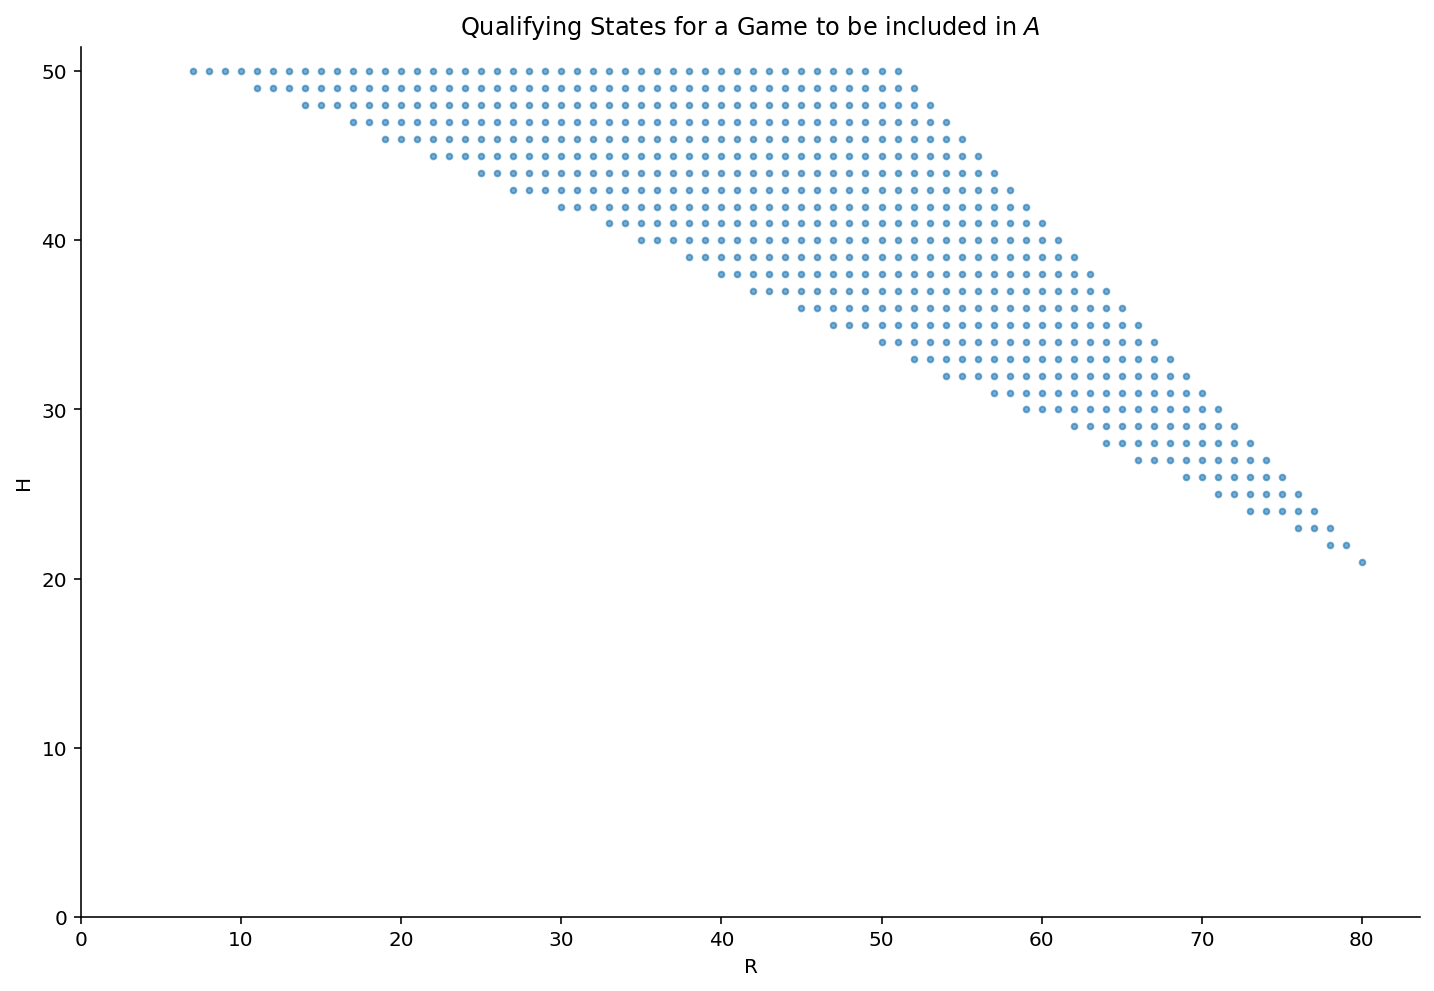

In [45]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Set global plot settings
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# Unpack coordinates
x, y = zip(*states_for_A)
r = np.array(x)
h = np.array(y)

# Plot
plt.scatter(r, h, alpha=0.6, s=8)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.title('Qualifying States for a Game to be included in $A$')
plt.xlabel('R')
plt.ylabel('H')
plt.show()

We can transform the above by using the identity we established: $T = 101 - (H+R)$. We can then also plot the constraint that a completed game must consist of $101$ flips where each flip is either a heads or a tails. 

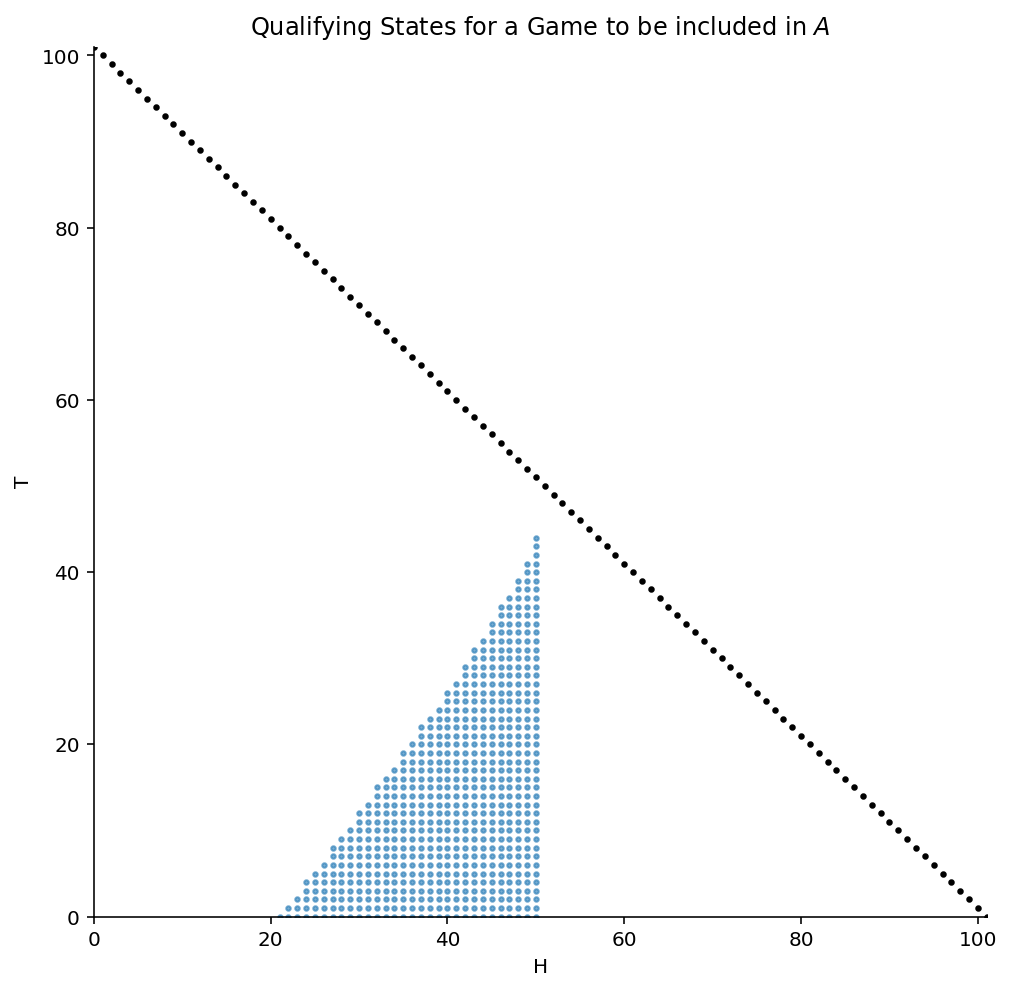

In [48]:
# Use identity
t = 101 - (h + r)

x = np.arange(0, 101+1)
end_game = 101 - np.arange(0, 101+1)

# Plot
plt.figure(figsize=(8, 8))
plt.scatter(h, t, alpha=0.6, s=5)
plt.scatter(x, end_game, s=5,color='black')
plt.xlim(left=0, right=101)
plt.ylim(bottom=0, top=101)
plt.title('Qualifying States for a Game to be included in $A$')
plt.xlabel('H')
plt.ylabel('T')
plt.show()


This gives us a nice geometric interpretation: a **game is any path from the origin** (using Manhattan blocks) **to a red dot**. A **game that qualifies for event $A$** is one that **goes through at least one blue dot**. For example, from our earlier observation, we also see that the path strictly up or the to right from the point of the highest blue dot is length $6$.

## From Game States to Games

We can quickly compute all the number of all possible game since there are $101$ tosses in total:

$$
|S| = 2^{101} \approx 2.5353012 \times 10^{30}
$$

Admittedly, searching all $2^{101}$ games where $A \cap B$ occur is a valid strategy, it seems a bit "bruce force"-y. Our intuition and the geometric interpretation above has already shed some light on constraints that can help us narrow down the amount of computation.

### Symmetry, Symmmetry, Symmetry

Hark back to the definition of the probability of the intersection of two events:

$$
P(A \cap B) = P(B \cap A) = P(B | A)P(A) = P(A | B)P(B)
$$

Rather than conditioning on $A$ let's proceed by conditioning on $B$! It's much easier to directly compute $P(B)$, i.e., the probability that the Birds lose:

$$
P(B) = P(W < 51) = \sum_{w=0}^{50} \binom{101}{w} \left(\frac{1}{2}\right)^{101}
$$

We confirm below, that by symmetry, $P(B) = \frac{1}{2}$.

In [34]:
# Calculate P(B)
p_B = (0.5 ** 101) * sum(comb(101, w) for w in range(0, 50 +1))
p_B

0.5

We can use our geometric interpretation to help us reason through how to calculate $P(A | B)$. First we need to "zoom in" on the game outcomes that the Birds end up losing (colored red):

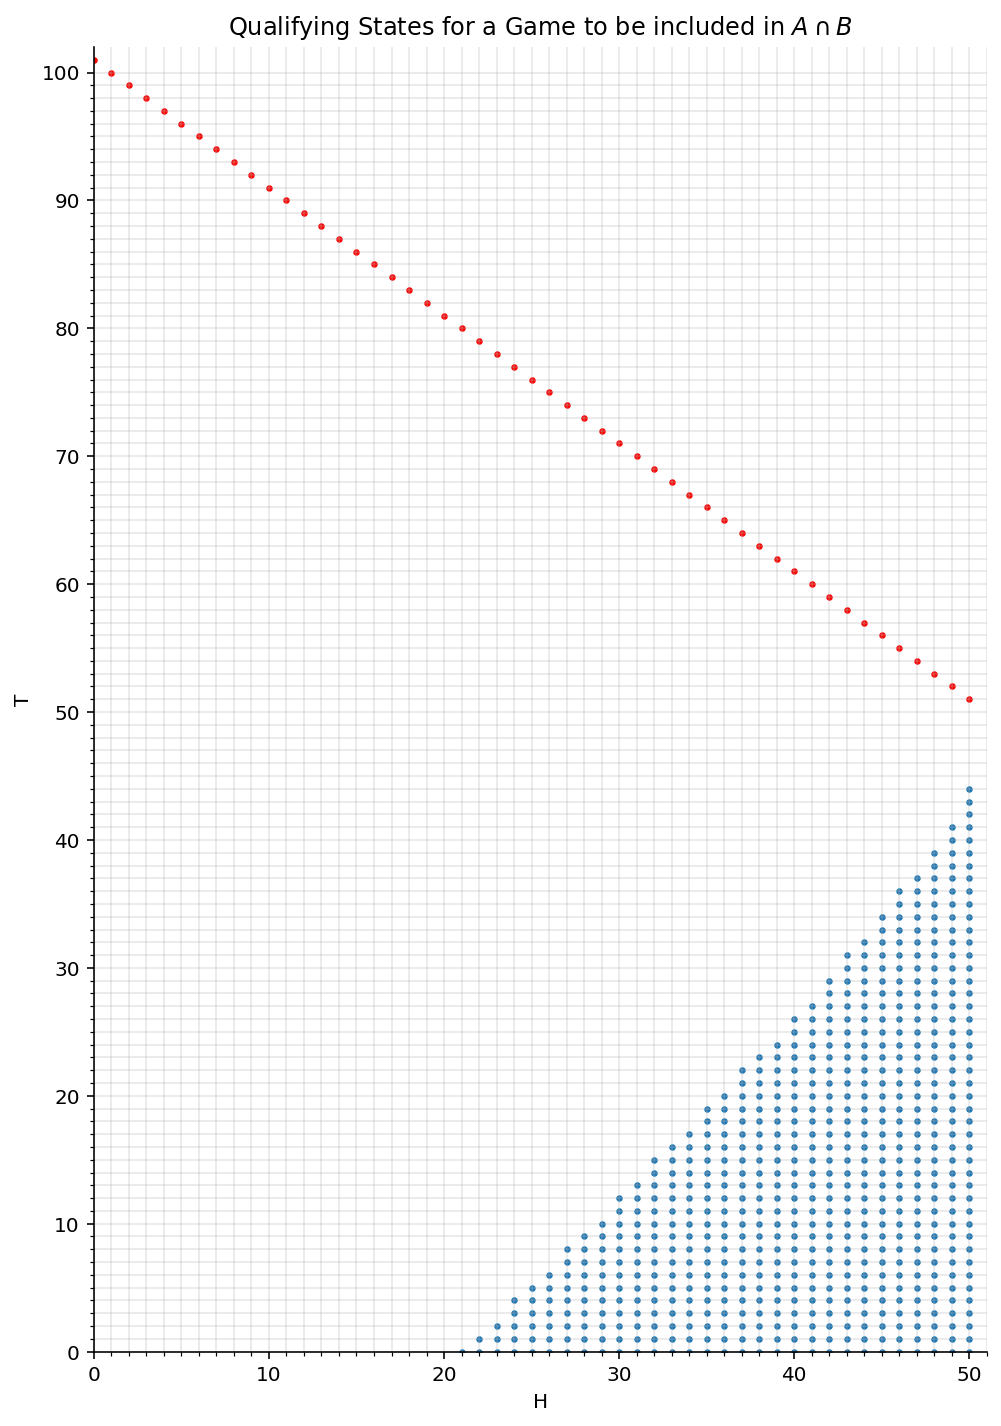

In [61]:
# Use identity
t = 101 - (h + r)

x = np.arange(0, 101+1)
end_game = 101 - np.arange(0, 101+1)

# Plot
plt.figure(figsize=(8, 12))

# Major, minor ticks
major_ticks = np.arange(0, 101, 10)
minor_ticks = np.arange(0, 101, 1)

ax = plt.gca()
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both', alpha=0.3)

plt.scatter(h, t, s=5)
plt.scatter(x[:51], end_game[:51], s=5,color='red')
plt.xlim(left=0, right=50+1)
plt.ylim(bottom=0, top=101+1)
plt.title('Qualifying States for a Game to be included in $A \cap B$')
plt.xlabel('H')
plt.ylabel('T')
plt.show()

So, we just need to **count all of the paths/games to each of the red dots above such that each path/game goes through at least one blue dot**. If we call this number $c$, then $P(A \cap B) = c\left(\frac{1}{2}\right)^{101}$.